# Term Project Progress Notebook - Manipulation and Analysis (NEW CONTINUING)

- Lindsey Rojtas
- LING1340
- ler75@pitt.edu

Welcome to the second Notebook! It should be noted that this is a **continuation** of `progress_data`! My progress report 3 starts there and will end here. 

# Contents
- [Loading in and investigating our data](#load-data)
- [Exploritory Analysis and Developing Questions](#expl-questions)
- [Addressing Double Counting](#dbl-count)
- [Length vs. Frequency](#lvf)
    - [Side Note: Revisiting Double Counting](#revisiting-dc)
    - [Visualizing Length vs. Frequency](#vis-lvf)
- [Fixing the Double Counting Issue](#dbl-fix)
- [Wrapping Up Length vs. Frequency](#final-lvf)
- [Age vs. Katakana Use](#avk)
- [Visualizing Age vs. Katakana and Adjusting Generations](#vis-avk)
- [Wrapping Up Age vs. Katakana](#final-avk)
- [Concluding Remarks](#concl)

## PROGRESS REPORT 3 CONTINUED
### Loading in and investigating our data <a class="anchor" id="load-data"></a>

Before anything else, we should load in those pickle files. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from scipy import stats

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline 

In [3]:
warnings.filterwarnings(action='ignore')

In [4]:
byfile = pd.read_pickle('../privdata/byfile_df.pkl')
bypar = pd.read_pickle('../privdata/byparticipant_df.pkl')
wordlist = pd.read_pickle('../privdata/wordlist_df.pkl')

In [5]:
byfile.head()

,file,participants,content
0,data001.txt,"[F107, F023, M023, F128]",[F107：＊＊＊の町というのはちいちゃくって、城壁がこう町全体をぐるっと回ってて、それが城...
1,data002.txt,"[F107, F023, F128]","[F107：今度はーイギリスにもアメリカと同様のテロが起こるだろうって言ったんだってよ。, ..."
2,data003.txt,"[F033, F056]","[F033：倒れちゃう。, F056：いきなり倒れた。, F033：どうしよう。あっ、この間..."
3,data004.txt,"[M018, F128]",[F128：いや、別にいいよ。ローソンでいいやろ。ちょっと倒していい、これ。どうよ、調子は。...
4,data005.txt,"[M023, F128, F116, M026]","[F128：来てたときによく貸してもらったやつだ。, M023：そう、そんな感じのとこ。, ..."


In [6]:
bypar.head()

,participant,age,appears_count,appears_in,content
0,F001,Early 20s,5,"[data105.txt, data086.txt, data076.txt, data07...",うーん、わかんない。そういうこと言わないで。うるさいな。うるさい。うるさいって言ってるの。う...
1,F002,Late 60's,3,"[data033.txt, data032.txt, data031.txt]",２７歳から現在まで東京都に居住。南仏へいらしたそうだけど、（うん）どうでしたか。みんな、太っ...
2,F003,Late 80's,1,[data129.txt],そうねえ。＜笑い＞先生はね、師範卒業したのがねえ、１９歳だったのよ。だーから、若い先生でね。...
3,F004,Late 20's,14,"[data096.txt, data094.txt, data092.txt, data08...",うん、まあね。はい、もう始まってますからね。よろしくね。ちょっとちょっと、ちゃんとさ、つなぐ...
4,F005,Late 20's,3,"[data052.txt, data023.txt, data015.txt]",はーい。いや、F034さんってー、やっぱりー、ハンバーガーとか好きですよねー。＊はなしを＊。...


In [7]:
wordlist.head()

,katakana,translation,frequency
0,パーセント,percent,63392
1,アメリカ,America,28243
2,ページ,page,24642
3,センター,center,20664
4,サービス,service,16630


### Exploratory Analysis and Developing Questions<a class="anchor" id="expl-questions"></a>
So, let's get some structure in here. What I'm gonna do next is check the length of everything as well as check for some potential issues that will come about in our analysis. 

In [8]:
len(wordlist)

5192

So there are around 5,000 entries in our list of Katakana words.... 

In [9]:
len(bypar)

197

... 197 participants... 

In [10]:
len(byfile)

129

... who spoke in 129 files. It's pretty easy to see that not everyone spoke in the same amount of files for the same amount of time, so we should examine the data for potential outliers. One thing I can think of off the top of my head is how many times a certain participant was present in the conversations. We can see that F004 was present in 14 different files, so obviously she will have more conversation data than anyone else, unless her contributions in many of the files were marginal. Let's take a peek at some value counts:

In [11]:
occ = bypar['appears_count'].value_counts()

Text(0.5, 1.0, 'number of files per participant')

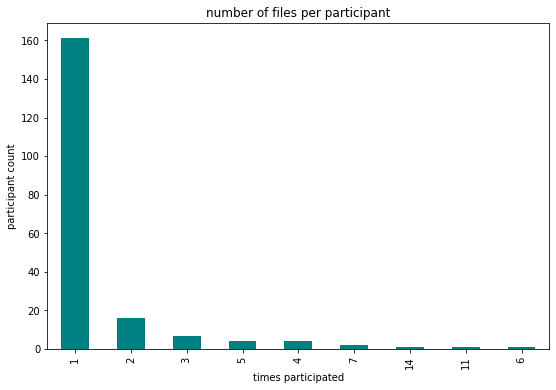

In [12]:
ax1 = occ.plot(kind='bar', figsize=(9, 6), color='teal')
ax1.set_ylabel('participant count')
ax1.set_xlabel('times participated')
ax1.set_title('number of files per participant')

Ah, so we're seeing a problem here. The majority of the participants only appeared in one file, but there are quite a few outliers here. I could just exclude them from my analysis from the get-go, but we should probably see just how long the strings of text are for each participant. 

In [13]:
bypar['length'] = 0
for i in range(len(bypar)):
    bypar['length'][i] = len(bypar['content'][i])

In [14]:
bypar.head()

,participant,age,appears_count,appears_in,content,length
0,F001,Early 20s,5,"[data105.txt, data086.txt, data076.txt, data07...",うーん、わかんない。そういうこと言わないで。うるさいな。うるさい。うるさいって言ってるの。う...,36989
1,F002,Late 60's,3,"[data033.txt, data032.txt, data031.txt]",２７歳から現在まで東京都に居住。南仏へいらしたそうだけど、（うん）どうでしたか。みんな、太っ...,27372
2,F003,Late 80's,1,[data129.txt],そうねえ。＜笑い＞先生はね、師範卒業したのがねえ、１９歳だったのよ。だーから、若い先生でね。...,5615
3,F004,Late 20's,14,"[data096.txt, data094.txt, data092.txt, data08...",うん、まあね。はい、もう始まってますからね。よろしくね。ちょっとちょっと、ちゃんとさ、つなぐ...,133395
4,F005,Late 20's,3,"[data052.txt, data023.txt, data015.txt]",はーい。いや、F034さんってー、やっぱりー、ハンバーガーとか好きですよねー。＊はなしを＊。...,24084


In [15]:
bypar['length'].describe()

count       197.000000
mean      12055.725888
std       14839.251277
min         458.000000
25%        5683.000000
50%        8206.000000
75%       12992.000000
max      133395.000000
Name: length, dtype: float64

So there are some wildly different levels of contribution here. We see that F004 has way more contributions than even the 75th percentile - this is not surprising, but it is something we really need to take into account if we find that she used a ton of Katakana. A way we could approach this is take a ratio of Katakana characters to overall characters. This, though, could be an issue because onomatopoeia words are also written in Katakana. It may be something worth trying, however. Another option I could try is just dropping anyone that participated in one or two conversations. I might try both (or more things!) in an attempt to see how the results differ -- maybe younger people use more onomatopoeia than older people too!

Now, let's test out some methods of gathering up how often these words are used in these files. Below is a line of code I used to see on what level in a dataframe a word would be detected:

In [16]:
word = 'アメリカ' # "amerika" = america
word in byfile['content'][1][0]

True

We can see here that it's probably a good thing that we kept everyone's utterances in one big long string, because that eliminates one more level of a data hierarchy to go into.  

In [17]:
ct = 0
for i in range(len(bypar)):
    if word in bypar['content'][i]:
        ct += 1
print(ct)

69


So this means that the word for America appears 69 times in this dataset. Let's try another common word:

In [18]:
word = "パーセント" # paasento = percent
ct = 0
for i in range(len(bypar)):
    if word in bypar['content'][i]:
        ct += 1
print(ct)

3


In [19]:
word = "テレビ" # terebi = television
ct = 0
for i in range(len(bypar)):
    if word in bypar['content'][i]:
        ct += 1
print(ct)

76


So the word for percent only shows up 3 times, but the word for television shows up 76 times... this makes sense since the word "percent" doesn't typically appear in casual conversation but "television" does. It seems likely that the frequencies in `wordlist` and the frequencies as far as how often these things actually appear in conversation. We could probably save some time from further analysis if we get rid of words that don't appear at all in these conversations. Let's do that now. 

In [20]:
wordlist['conv_freq'] = ''

In [21]:
for i in range(len(wordlist)):
    word =  wordlist['katakana'][i]
    ct = 0
    for j in range(len(bypar)):
        if word in bypar['content'][j]:
            ct += 1
    if ct == 0:
        wordlist['conv_freq'][i] = None
    else:
        wordlist['conv_freq'][i] = ct

In [22]:
wordlist.head(15)

,katakana,translation,frequency,conv_freq
0,パーセント,percent,63392,3
1,アメリカ,America,28243,69
2,ページ,page,24642,27
3,センター,center,20664,33
4,サービス,service,16630,21
5,システム,system,16458,17
6,メートル,metre,15960,17
7,テレビ,television,15644,76
8,メール,mail,15589,72
9,データ,data,13210,28


Again, the frequency column doesn't reflect how frequently these words appear in these conversation files. Let's drop words we don't see. 

In [23]:
wordlist = wordlist.dropna()

In [24]:
wordlist = wordlist.reset_index(drop=True)

In [25]:
wordlist.head(15)

,katakana,translation,frequency,conv_freq
0,パーセント,percent,63392,3
1,アメリカ,America,28243,69
2,ページ,page,24642,27
3,センター,center,20664,33
4,サービス,service,16630,21
5,システム,system,16458,17
6,メートル,metre,15960,17
7,テレビ,television,15644,76
8,メール,mail,15589,72
9,データ,data,13210,28


In [26]:
len(wordlist)

2734

We cut our amount of words in half, wow. I wonder what the most frequently used word in these conversations was:

In [27]:
wordlist['conv_freq'].max()

193

In [28]:
wordlist['translation'][pd.Index(wordlist['conv_freq']).get_loc(193)]

'la'

### Addressing Double Counting <a class="anchor" id="dbl-count"></a>
So here's another issue: the word for "la" (ラ) is probably only so frequent because it has the potential to appear in other words. 

In [29]:
for i in range(len(wordlist)):
    if 'ラ' in wordlist['katakana'][i]:
        print(wordlist['katakana'][i], end = ', ')

フランス, クラブ, ライン, カメラ, バランス, クラス, プログラム, ガラス, ドラマ, カラー, ブランド, ボランティア, プラス, ラジオ, レストラン, トラブル, ライブ, ドライブ, プラン, トラック, ラーメン, サラダ, イスラム, イラク, グラス, ラブ, オランダ, グラフ, ラン, オーストラリア, ランキング, ドライバー, ブラック, サラリーマン, ライフ, ランド, ブラジル, ランチ, キャラクター, ライト, キャラ, イスラエル, イラスト, プラスチック, オペラ, イラン, アラブ, ラッキー, ランプ, リラックス, グランド, コラム, ラベル, ライバル, ブラシ, ランク, ラウンド, ライター, ライオン, クラシック, グラウンド, ライト, ラスト, プライド, プライバシー, エラー, ベランダ, カメラマン, フライ, ドラゴン, リストラ, ウラン, マラソン, プライベート, ブラウン, ベテラン, ラ, ライダー, ラップ, ラテン, アラビア, コーラ, ミネラル, ドライ, ポーランド, マフラー, オーケストラ, ドラム, ライス, ピラミッド, フランク, ディーラー, クーラー, フォーラム, フラワー, フラッシュ, レギュラー, テラス, ラリー, ニュージーランド, プラント, ライセンス, ブラウス, サングラス, トランク, ライフスタイル, カウンセラー, セラー, ラッシュ, トライ, スライス, ストラップ, ミラノ, プラグ, モラル, オーラ, スコットランド, ミラー, キャラメル, ライト, フィンランド, ラグビー, カリキュラム, ランニング, マスカラ, フライト, アラン, バニラ, フラン, ララ, ローラ, カラフル, ポピュラー, ラフ, ブラン, ミラー, アトラクション, ラグ, ブラザー, ストライプ, ライナー, ミイラ, ストライク, プロペラ, フラ, ゴリラ, サウジアラビア, ラオス, ブラウン, ライ, トランプ, マニラ, ラット, スラム, トラスト, パノラマ, ドラフト, セントラル, ラム, ブラッド, ヒマラヤ, レスラー, ローラー, ブラインド, グラタン, シンデレラ, キラー, アイランド, セラピー, イ

That's a lot of words that are being counted as another usage of "la." Maybe we should look at all "words" that are only one character in length and drop those too. 

In [30]:
for i in range(len(wordlist)):
    if len(wordlist['katakana'][i]) == 1:
        wordlist['katakana'][i] = None

In [31]:
wordlist = wordlist.dropna()

In [32]:
wordlist = wordlist.reset_index(drop=True)

In [33]:
len(wordlist)

2722

Only a couple words dropped, but it'll make a big difference later on. Let's check the most frequent word again:

In [34]:
wordlist['conv_freq'].max()

138

In [35]:
wordlist['translation'][pd.Index(wordlist['conv_freq']).get_loc(138)]

'strike'

This is pretty neat! I wouldn't have expected this to be the most common word, but then again, I don't know what the conversation topics are. I'd investigate less-common words, but that's probably quite a few words. As I was debugging, I found a lot of words that only appeared once, but appeared nonetheless. It also seemed like my cutoff point back in progress report 1 was a good one; there were quite a few zero-frequency words towards the end of my list (part of my debugging process was to put print statements everywhere... not much else in the process other than trying to explain the code to my blissfully ignorant cat). 
  
### Length vs. Frequency <a class="anchor" id="lvf"></a>
I do want to check out the length of these words and compare it to their frequencies. I noted in the last progress report that a shortened version of the word for "centimeter" is used more frequently than the full version, so I'm going to investigate the relationship between length (both in Katakana characters and English translation) and usage, if there is any relationship to begin with. This is a question I've wanted to investigate since the beginning, before I even came up with the idea of comparing Katakana use to age. 

In [36]:
def getlen(w):
    ln = len(w)
    return ln

In [37]:
wordlist['kata_len'] = wordlist['katakana'].apply(getlen)
wordlist['tln_len'] = wordlist['translation'].apply(getlen)

In [38]:
wordlist.head()

,katakana,translation,frequency,conv_freq,kata_len,tln_len
0,パーセント,percent,63392,3,5,7
1,アメリカ,America,28243,69,4,7
2,ページ,page,24642,27,3,4
3,センター,center,20664,33,4,6
4,サービス,service,16630,21,4,7


In [39]:
wordlist['kata_len'].min()

2

In [40]:
wordlist['tln_len'].min()

1

In [41]:
wordlist['translation'][pd.Index(wordlist['kata_len']).get_loc(2)]

18         dollar
28            bus
33           kilo
35           door
39            one
          ...    
2684           外国
2686    agitation
2687         than
2699          jig
2713            I
Name: translation, Length: 383, dtype: object

In [42]:
wordlist['translation'][pd.Index(wordlist['tln_len']).get_loc(1)]

377     H
2158    四
2713    I
Name: translation, dtype: object

So as I was poking around, I noticed that even more of my words that I included should probably be dropped -- ones that don't seem to have been borrowed from English (外国 = foreign country). I really only want to focus on English borrowings, so let's just drop those real quick:

In [43]:
for i in range(len(wordlist)):
    if wordlist['translation'][i] == '外国' or wordlist['translation'][i] == '四':
        wordlist['translation'][i] = None

In [44]:
wordlist = wordlist.dropna()

In [45]:
wordlist = wordlist.reset_index(drop=True)

In [46]:
len(wordlist)

2612

We still have a pretty sizable list here, despite all that we dropped. There are some other considerations we should take here, like how the translation for "I" can also be used as a name or a word for "love", but I don't know how the word is being used in the conversation, so I'm going to leave it in.   

### Side Note: Revisiting Double Counting<a class="anchor" id="revisiting-dc"></a>

In my cleaning, I did notice that "agitation" was one of the many words that had a two-katakana length:

In [47]:
wordlist.loc[2577]

katakana              アジ
translation    agitation
frequency             77
conv_freq             23
kata_len               2
tln_len                9
Name: 2577, dtype: object

This is another word that I'm questioning the frequency of. アジ (aji) could also be part of other words. Let's do that same trick we pulled earlier.

In [48]:
for i in range(len(wordlist)):
    if 'アジ' in wordlist['katakana'][i]:
        print(wordlist['katakana'][i], end = ', ')

アジア, アジアン, アジト, アジ, 

This doesn't seem to be as big of a deal, but I'm going to double check how many times these words show up as well as just アジ. 

In [49]:
wordlist['conv_freq'][pd.Index(wordlist['katakana']).get_loc('アジアン')] # translation: asian 

3

In [50]:
wordlist['conv_freq'][pd.Index(wordlist['katakana']).get_loc('アジア')] # translation: asia

18

Note: there are three double-counts in here, so technically this word was used 15 times. 

In [51]:
wordlist['conv_freq'][pd.Index(wordlist['katakana']).get_loc('アジト')] # translation: agitating point

1

So アジ by itself was used, but not as much as these frequencies describe it to be. I'm going to call this issue quits for now because, frankly, I don't know where to go next with it. Feedback in the Guestbook or anywhere else is appreciated!

### Visualization: Length vs Frequency<a class="anchor" id="vis-lvf"></a>
We have two metrics of word length and two metrics of word frequency. There's stil a lot of words on this list, so I don't want to use all 2,000something of them, so I'm gonna visualize a couple of samples as well as some averages. 
  
  
In my sample graphs, I'll probably exclude the frequency given to me already in the data since the number is so large. I'm really going to look at words that have a longer translation length but a shorter Katakana length to try and find a correlation between length and frequency. 

In going through `wordlist.sample()` a bunch of times, I found words whose length is substantially shorter in Katakana than it is in English - ビル (biru = building), キャラ (kyara = character), and パソコン (pasukon = personal computer). As for longer words, I'm using デモンストレーション (demonsutoreeshon = demonstration) and コミュニケーション (komyunikeeshon = communication). For the sake of the graphs not looking terrible (because it'll be three smaller numbers with one huge number), I'll be ranking these words 1-5 (1 being least frequent as far as the dataset's listed web frequencies). 
  
  


In [52]:
toydict = {'word':['(character)', '(personal computer)', 
                       '(building)', '(demonstration)', # matplot doesn't like non-ascii characters
                       '(communication)'], 
           'relative freq in given data':[10, 25, 20, 5, 15], # multiples of five so the graph looks less gross
          'freq in conversational data':[19, 33, 18, 3, 19],
          'length of katakana word':[3, 4, 2, 10, 9]}

In [53]:
samplefreq_df = pd.DataFrame.from_dict(toydict)

In [54]:
samplefreq_df

,word,relative freq in given data,freq in conversational data,length of katakana word
0,(character),10,19,3
1,(personal computer),25,33,4
2,(building),20,18,2
3,(demonstration),5,3,10
4,(communication),15,19,9


Text(0.5, 0, 'translated word')

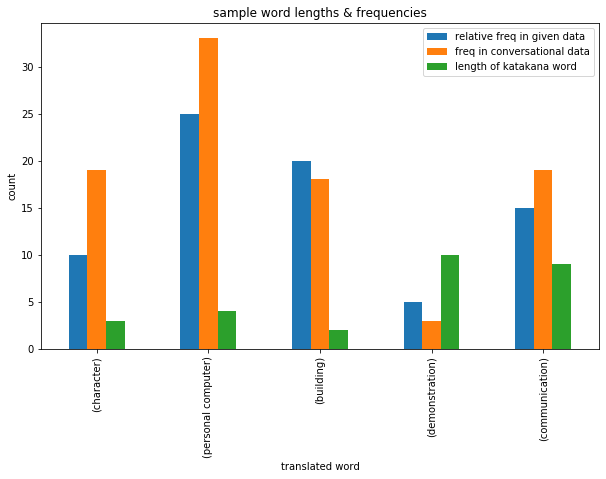

In [55]:
ax2 = samplefreq_df.plot(x="word", title="sample word lengths & frequencies", kind="bar", figsize=(10,6))
ax2.set_ylabel('count')
ax2.set_xlabel('translated word')

There seems to be some sort of correlation between length and frequency here. Of course, there aren't any comparisons between other words and their shortenings, but in the case of the shorter words, there isn't any long versions that we can use. We can check out "demonstration", though -- I know "demo" is in this word list, but I'm not sure if it shows up outside of where "demonstration" is used. Let's take a peek. 
  
First, I'm going to make sure デモ doesn't come up anywhere else, since we'd have to take double counting into account

In [56]:
for i in range(len(wordlist)):
    if 'デモ' in wordlist['katakana'][i]:
        print(wordlist['katakana'][i], end = ', ')

デモ, デモンストレーション, 

Good -- it's just "demo" and "demonstration."

In [57]:
wordlist['conv_freq'][pd.Index(wordlist['katakana']).get_loc('デモンストレーション')] # translation: demonstration

3

In [58]:
wordlist['conv_freq'][pd.Index(wordlist['katakana']).get_loc('デモ')] # translation: demo 

9

Since we have to take double counting into account, the actual conversational frequency of デモ is 6. That is still twice the amount of uses as the longer word for "demonstration." We can generalize here that word length and frequency are negatively correlated; the shorter the word, the more frequent the usage. This is not what I'm more focused on in the bigger picture though -- in a moment, I'll look at age vs katakana usage, but I'm going to take care of one more thing regarding double counting really quick. 

### Fixing the Double Counting Issue (post-progress report 3)<a class="anchor" id="dbl-fix"></a>
  
As Jevon mentioned in my progress report 3 comment, a POS tagger would definitely be useful as far as doublecounting, but as he said (and I very much agree with), it's a bit late in the game for that. 
  
  
John did mention that "strike" was a pretty suspicious common word, so let's look at it real quick:

In [59]:
wordlist['katakana'][pd.Index(wordlist['conv_freq']).get_loc(138)]

'スト'

Umm, yeah, that'll appear pretty frequently. Let's see where else スト (suto) shows up. 

In [60]:
for i in range(len(wordlist)):
    if 'スト' in wordlist['katakana'][i]:
        print(wordlist['katakana'][i], end = ', ')

コスト, キリスト, テスト, ストレス, ベスト, レストラン, リスト, テキスト, オーストラリア, ストーリー, イラスト, ポスト, ゲスト, ファースト, アーチスト, ストレート, ストップ, ラスト, ジャーナリスト, ストリート, リストラ, ストア, ストレッチ, ホスト, ウエスト, オーケストラ, キャスト, ストーン, リクエスト, ポスト, ボストン, コンテスト, ストーブ, ストラップ, テロリスト, ピストル, スト, トースト, ピアニスト, スタイリスト, ストーカー, ストッキング, ストライプ, ストライク, イースト, トラスト, ファースト, ヒストリー, ロースト, インストラクター, ウエスト, ジャスト, エキストラ, ゴースト, ダスト, コンテキスト, ストロベリー, エコノミスト, レスト, クエスト, ストーン, ストリップ, ストロング, デモンストレーション, イースト, バイオリニスト, ツーリスト, ポストカード, ストラクチャー, フォレスト, ネスト, 

Yeahhh, might wanna do the same thing here that we did with ラ. I didn't pay "strike" any mind at first because I thought that it would be the longer, unshortened version of the word, ストライク (sutoraiku), so it's on me that I didn't look into it further. 

In [61]:
for i in range(len(wordlist)):
    if wordlist['katakana'][i] == 'スト':
        wordlist['katakana'][i] = None

In [62]:
wordlist = wordlist.dropna()
wordlist = wordlist.reset_index(drop=True)

In [63]:
len(wordlist) # should be 2611

2611

In [64]:
# checking again... 
wordlist['translation'][pd.Index(wordlist['conv_freq']).get_loc(wordlist['conv_freq'].max())]

'Lee'

Now, this doesn't seem all that likely either... a quick solution here would be to drop any katakana words that are 2 characters long, but there are some two-character words that aren't prone to double counting (re: demo vs demonstration). I'm just going to drop this word and drop words with shorter translations to get rid of stop words that might trip up the word counter. 

In [65]:
for i in range(len(wordlist)):
    if wordlist['katakana'][i] == 'リー':
        wordlist['katakana'][i] = None

In [66]:
for i in range(len(wordlist)): # many of these are function/stop words... others are gibberish. 
    if len(wordlist['translation'][i]) < 3: # let's get rid of them!
        print(wordlist['translation'][i], end=' ')

up in on of my no to by H go at or me do is be ti al di Es je we if Po ad am ja an Ur I 

In [67]:
for i in range(len(wordlist)): 
    if len(wordlist['translation'][i]) < 3: 
        wordlist['katakana'][i] = None

In [68]:
wordlist = wordlist.dropna()
wordlist = wordlist.reset_index(drop=True)

In [69]:
len(wordlist)

2580

In [70]:
for i in range(len(wordlist)): # removing some shorter names/proper nouns 
    if len(wordlist['translation'][i]) < 4 and not wordlist['translation'][i].islower(): 
        wordlist['katakana'][i] = None

In [71]:
wordlist = wordlist.dropna()
wordlist = wordlist.reset_index(drop=True)

In [72]:
len(wordlist)

2544

In [73]:
wordlist['translation'][pd.Index(wordlist['conv_freq']).get_loc(wordlist['conv_freq'].max())]
# umm... this isn't likely, but i can't think of a more generalized way to drop it

'run'

This is getting to be a very obnoxious and lengthy process. I figured there would be a simpler way to do this, so I devised a plan: a loop that would go through the word list twice and subtract all the frequencies that were inflated by doublecounting. 

In [74]:
for i in range(len(wordlist)):
    word = wordlist['katakana'][i]
    for j in range(len(wordlist)):
        if word in wordlist['katakana'][j] and not word == wordlist['katakana'][j]:
            wordlist['conv_freq'][i] = wordlist['conv_freq'][i] - wordlist['conv_freq'][j]

In [75]:
for i in range(len(wordlist)):
    if wordlist['conv_freq'][i] <= 0:
        print(wordlist['translation'][i], wordlist['katakana'][i], end=', ')

pro プロ, man マン, bar バー, car カー, tel テル, star スター, new ニュー, Thailand タイ, part パート, day デー, John ジョン, run ラン, goal ゴール, sun サン, ring リング, range レンジ, market マーケット, cycle サイクル, Iran イラン, bell ベル, rear リア, eco エコ, Wien ウィーン, round ラウンド, mile マイル, venture  ベンチャー, mass マス, combination コンビ, pin ピン, port ポート, for フォー, cloth クロース, money マネー, roll ロール, Rhodes ローズ, Arabia アラビア, Philippe フィリップ, clean クリーン, core コア, sale セール, Frank フランク, rain レーン, Nick ニック, pre プレ, law ロー, four フォー, par パー, loop ループ, arch アーチ, tone トーン, fur ファー, less レス, location ロケ, stick スティック, channel チャン, trick トリック, through スルー, are アー, pinta ピン, yard ヤード, Khan ハン, sea シー, pea ピー, running ランニング, tie タイ, Scott スコット, age エージ, stay ステー, franc フラン, concert コン, bull ブル, Lynn リン, Lenin レーニン, Mark マルク, Long ロン, missa ミサ, parka パーカ, pull プル, river リバー, hula フラ, roux ルー, crew クルー, knee ニー, rye ライ, Bell ベル, ware ウェア, meta メタ, tongue タン, rum ラム, der デア, kali カリ, foot フット, joule ジュール, beau ボー, pain ペイン, mart マート, clitoris クリ, motion モーション,

This seems to have worked. There are some odd finds here, like "grape" and "clean" and "caliph", but those were all the result of the words "grapefruit", "screen", and "California." I went through and tested the more suspicious words, and all of them had at least one word that contributed to their double counting. That said, let's drop these!

In [76]:
for i in range(len(wordlist)):
    if wordlist['conv_freq'][i] <= 0:
        wordlist['katakana'][i] = None


In [77]:
wordlist = wordlist.dropna()
wordlist = wordlist.reset_index(drop=True)

In [78]:
len(wordlist) # dropped 200ish words...

2345

In [79]:
wordlist['katakana'][pd.Index(wordlist['conv_freq']).get_loc(wordlist['conv_freq'].max())]

'テレビ'

This looks very very promising... テレビ means "television" and is a pretty common word. Let's go back to demo from earlier; double counted, it appeared nine times, but it should've only appeared six:

In [80]:
wordlist['conv_freq'][pd.Index(wordlist['katakana']).get_loc('デモ')] # is it 6?

6

Success! Didn't need a POS tagger at all.   
  
### Wrapping Up Length vs. Frequency<a class="anchor" id="final-lvf"></a>

That said, let's do a quick Spearman Rho correlation check and add in some visualization for this length-vs-frequency analysis:

In [81]:
stats.spearmanr(wordlist['kata_len'], wordlist['conv_freq']).correlation 

-0.25779559889473475

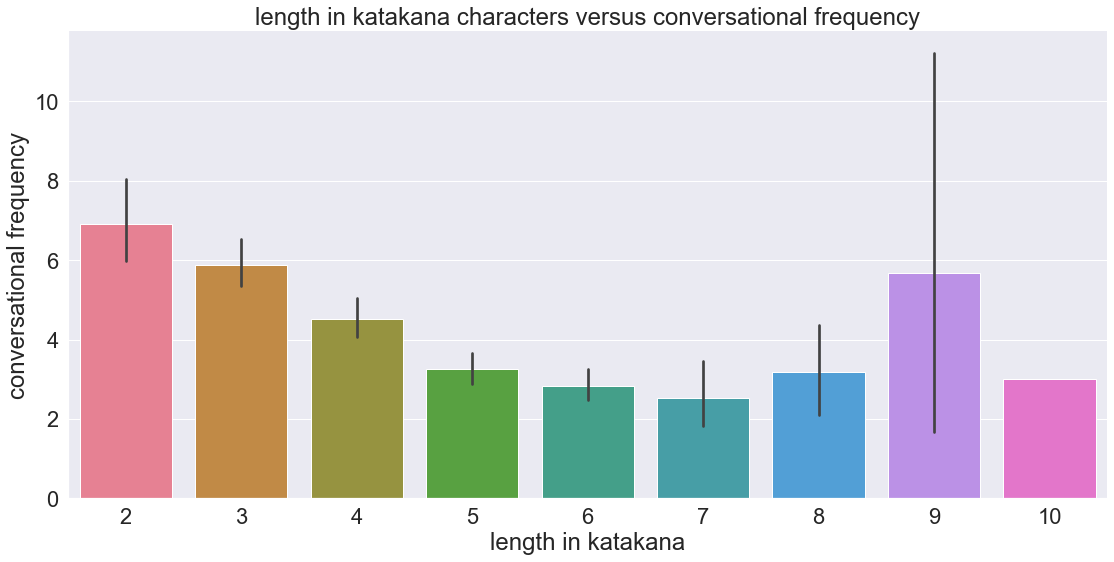

In [82]:
sns.set(font_scale=2)
ax3 = sns.catplot(x='kata_len', y='conv_freq', data=wordlist, kind='bar', height=8, aspect=2, palette="husl")
ax3.set(title="length in katakana characters versus conversational frequency", xlabel="length in katakana", ylabel="conversational frequency")

A -0.25 correlation indicates a moderate correlation, but it's on the way lower end of moderate. It's still enough for there to be a correlation, though. To conclude our length analysis: **there is a low-end moderate negative correlation between length in katakana and conversational frequency for Japanese loan words.**

### Age vs Katakana Usage<a class="anchor" id="avk"></a>
Now, let's (finally) take a look at age! First and foremost, I need to find how many katakana words by each participant. I'm going to make use of the `count` string function here to add up all the times a certain word appears in a certain participant's conversation string. I'll do this for all of the words (another nested for loop... I'm not happy about it either) and then move on to analysis with a mixed effects model. 

In [83]:
bypar['kata_count'] = 0
for i in range(len(bypar)):
    st = bypar['content'][i]
    tmp = 0
    for j in range(len(wordlist)):
        word = wordlist['katakana'][j]
        tmp = st.count(word)
        bypar['kata_count'][i] += tmp
    

In [84]:
bypar.head()

,participant,age,appears_count,appears_in,content,length,kata_count
0,F001,Early 20s,5,"[data105.txt, data086.txt, data076.txt, data07...",うーん、わかんない。そういうこと言わないで。うるさいな。うるさい。うるさいって言ってるの。う...,36989,496
1,F002,Late 60's,3,"[data033.txt, data032.txt, data031.txt]",２７歳から現在まで東京都に居住。南仏へいらしたそうだけど、（うん）どうでしたか。みんな、太っ...,27372,491
2,F003,Late 80's,1,[data129.txt],そうねえ。＜笑い＞先生はね、師範卒業したのがねえ、１９歳だったのよ。だーから、若い先生でね。...,5615,8
3,F004,Late 20's,14,"[data096.txt, data094.txt, data092.txt, data08...",うん、まあね。はい、もう始まってますからね。よろしくね。ちょっとちょっと、ちゃんとさ、つなぐ...,133395,1556
4,F005,Late 20's,3,"[data052.txt, data023.txt, data015.txt]",はーい。いや、F034さんってー、やっぱりー、ハンバーガーとか好きですよねー。＊はなしを＊。...,24084,309


In [85]:
bypar.sample(5)

,participant,age,appears_count,appears_in,content,length,kata_count
3,F004,Late 20's,14,"[data096.txt, data094.txt, data092.txt, data08...",うん、まあね。はい、もう始まってますからね。よろしくね。ちょっとちょっと、ちゃんとさ、つなぐ...,133395,1556
110,F113,Late 40's,1,"[data015.txt, ]",＊＊＊ね、ちょっと比べられない。（そんなすごいんだ）でも若いんだね。やっぱりね。（へえ）あー...,10117,40
37,F039,Early 30s,1,[data050.txt],そういうときは、どうするのかな。ほっとくんかな。録れなかった音。それも、一環として。（うん）...,13568,105
44,F046,Late teens,1,[data072.txt],もう今から？（うん）録音されてる？うん、なってるなってる。大丈夫じゃない？これさ、もうこの辺...,13521,216
52,F054,Early 30s,1,[data122.txt],バーゲンいつからだっけ。え、てか、小樽とかはどう？なんか今日水曜日なのにー、（うん）なんかす...,12362,64


This is looking interesting. Generally, it looks like younger speakers are using more katakana words, but at the same time, some speakers speak way more than others. This said, I'm going to take a ratio of katakana word count to length 

In [86]:
bypar['kata_len_ratio'] = 0.0

In [87]:
for i in range (len(bypar)):
    bypar['kata_len_ratio'][i] =  bypar['kata_count'][i] / bypar['length'][i]

In [88]:
bypar.head()

,participant,age,appears_count,appears_in,content,length,kata_count,kata_len_ratio
0,F001,Early 20s,5,"[data105.txt, data086.txt, data076.txt, data07...",うーん、わかんない。そういうこと言わないで。うるさいな。うるさい。うるさいって言ってるの。う...,36989,496,0.013409
1,F002,Late 60's,3,"[data033.txt, data032.txt, data031.txt]",２７歳から現在まで東京都に居住。南仏へいらしたそうだけど、（うん）どうでしたか。みんな、太っ...,27372,491,0.017938
2,F003,Late 80's,1,[data129.txt],そうねえ。＜笑い＞先生はね、師範卒業したのがねえ、１９歳だったのよ。だーから、若い先生でね。...,5615,8,0.001425
3,F004,Late 20's,14,"[data096.txt, data094.txt, data092.txt, data08...",うん、まあね。はい、もう始まってますからね。よろしくね。ちょっとちょっと、ちゃんとさ、つなぐ...,133395,1556,0.011665
4,F005,Late 20's,3,"[data052.txt, data023.txt, data015.txt]",はーい。いや、F034さんってー、やっぱりー、ハンバーガーとか好きですよねー。＊はなしを＊。...,24084,309,0.012830


In [89]:
bypar.describe()

,appears_count,length,kata_count,kata_len_ratio
count,197.000000,197.000000,197.000000,197.000000
mean,1.497462,12055.725888,147.573604,0.012494
std,1.534050,14839.251277,190.073028,0.006870
min,1.000000,458.000000,4.000000,0.001425
25%,1.000000,5683.000000,52.000000,0.007726
50%,1.000000,8206.000000,91.000000,0.011653
75%,1.000000,12992.000000,157.000000,0.015037
max,14.000000,133395.000000,1556.000000,0.040199


Let's look at the age groups of the smallest and largest katakana to age ratios:

In [90]:
bypar['age'][pd.Index(bypar['kata_len_ratio']).get_loc(bypar['kata_len_ratio'].max())]
# by hypothesis, should be younger

"Late 20's"

In [91]:
bypar['age'][pd.Index(bypar['kata_len_ratio']).get_loc(bypar['kata_len_ratio'].min())]
# by hypothesis, should be older

"Late 80's"

Neat, we're getting somewhere. These results look promising, but we don't know what's between them. For the sake of making this easier and because I wanted to do this anyway, I'm going to put the participants into categories based on the *decade* of age they're in. This is to account for the person whose age is just "50s" with no late/early, and it'll also be less columns to look at later. 

In [92]:
bypar['age_group'] = None
bypar['age_group_num'] = None
for i in range(len(bypar)):
    if bypar['age'][i] == "Early teens" or bypar['age'][i] == "Late teens":
        bypar['age_group'][i] = "Teens"
    elif bypar['age'][i] == "Early 20s" or bypar['age'][i] == "Late 20's":
        bypar['age_group'][i] = "Twenties"
    elif bypar['age'][i] == "Early 30s" or bypar['age'][i] == "Late 30's":
        bypar['age_group'][i] = "Thirties"
    elif bypar['age'][i] == "Early 40's" or bypar['age'][i] == "Late 40's":
        bypar['age_group'][i] = "Forties"
    elif bypar['age'][i] == "Early 50's" or bypar['age'][i] == "Late 50's" or bypar['age'][i] == "50s":
        bypar['age_group'][i] = "Fifties"
    elif bypar['age'][i] == "Early 60's" or bypar['age'][i] == "Late 60's":
        bypar['age_group'][i] = "Sixties"
    elif bypar['age'][i] == "Late 70's":
        bypar['age_group'][i] = "Seventies"
    else:
        bypar['age_group'][i] = "Eighties to Nineties" # only one 80s, so just grouping the 90s in with them
        
# doing numbers too because my spearman's rho was being weird with the strings
for i in range(len(bypar)):
    if bypar['age'][i] == "Early teens" or bypar['age'][i] == "Late teens":
        bypar['age_group_num'][i] = 10
    elif bypar['age'][i] == "Early 20s" or bypar['age'][i] == "Late 20's":
        bypar['age_group_num'][i] = 20
    elif bypar['age'][i] == "Early 30s" or bypar['age'][i] == "Late 30's":
        bypar['age_group_num'][i] = 30
    elif bypar['age'][i] == "Early 40's" or bypar['age'][i] == "Late 40's":
        bypar['age_group_num'][i] = 40
    elif bypar['age'][i] == "Early 50's" or bypar['age'][i] == "Late 50's" or bypar['age'][i] == "50s":
        bypar['age_group_num'][i] = 50
    elif bypar['age'][i] == "Early 60's" or bypar['age'][i] == "Late 60's":
        bypar['age_group_num'][i] = 60 
    elif bypar['age'][i] == "Late 70's":
        bypar['age_group_num'][i] = 70
    else:
        bypar['age_group_num'][i] = 80 

### Visualizing Age vs Katakana and Adjusting Generations<a class="anchor" id="vis-avk"></a>
Next, I'm going to regroup these so they're in a pretty order for the plots that will follow: a box plot and a swarm plot with some pretty colors! `husl` is very pretty. Before that, though, I gotta reorder these word labels so they appear in order on the plots. 

In [93]:
bypar['age_group'] = pd.Categorical(bypar['age_group'], ["Teens", "Twenties", "Thirties", "Forties", "Fifties", "Sixties", "Seventies", "Eighties to Nineties"])

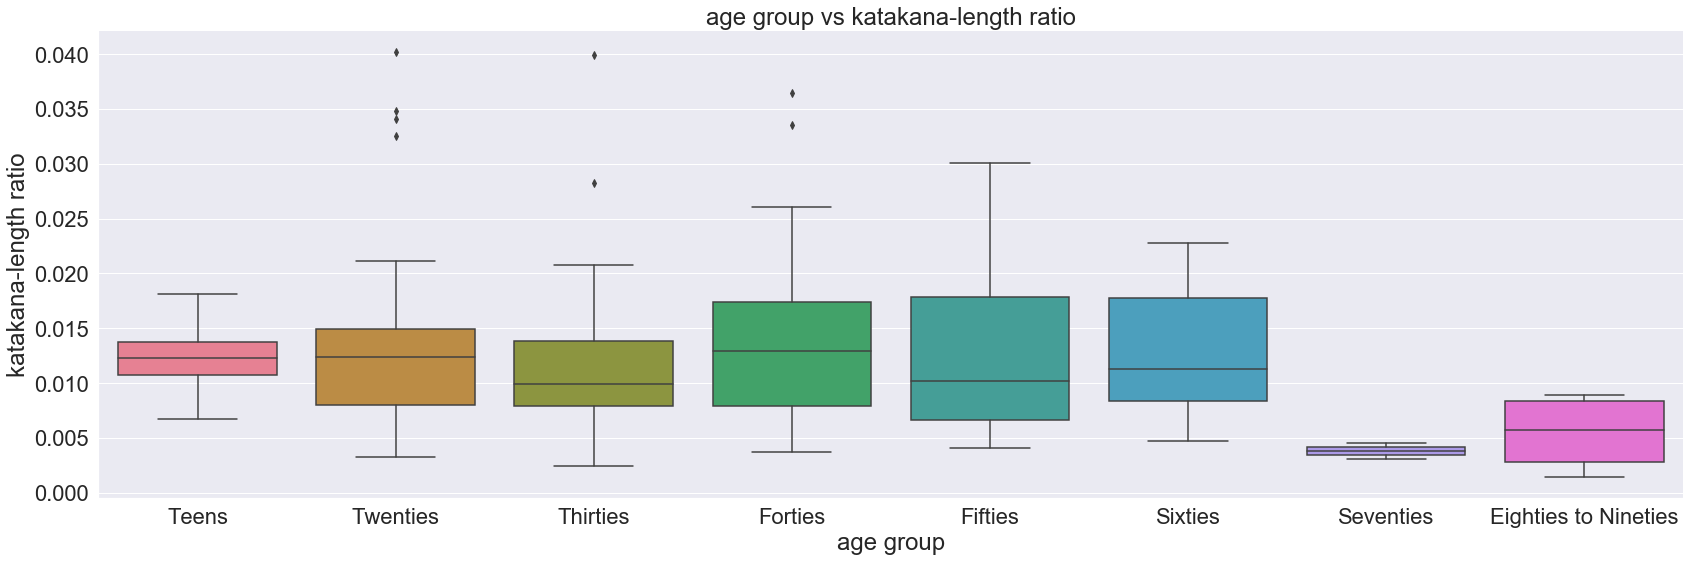

In [94]:

ax4 = sns.catplot(x='age_group', y='kata_len_ratio', kind='box', data=bypar, height=8, aspect=3, palette="husl")
ax4.set(title="age group vs katakana-length ratio", xlabel="age group", ylabel="katakana-length ratio")

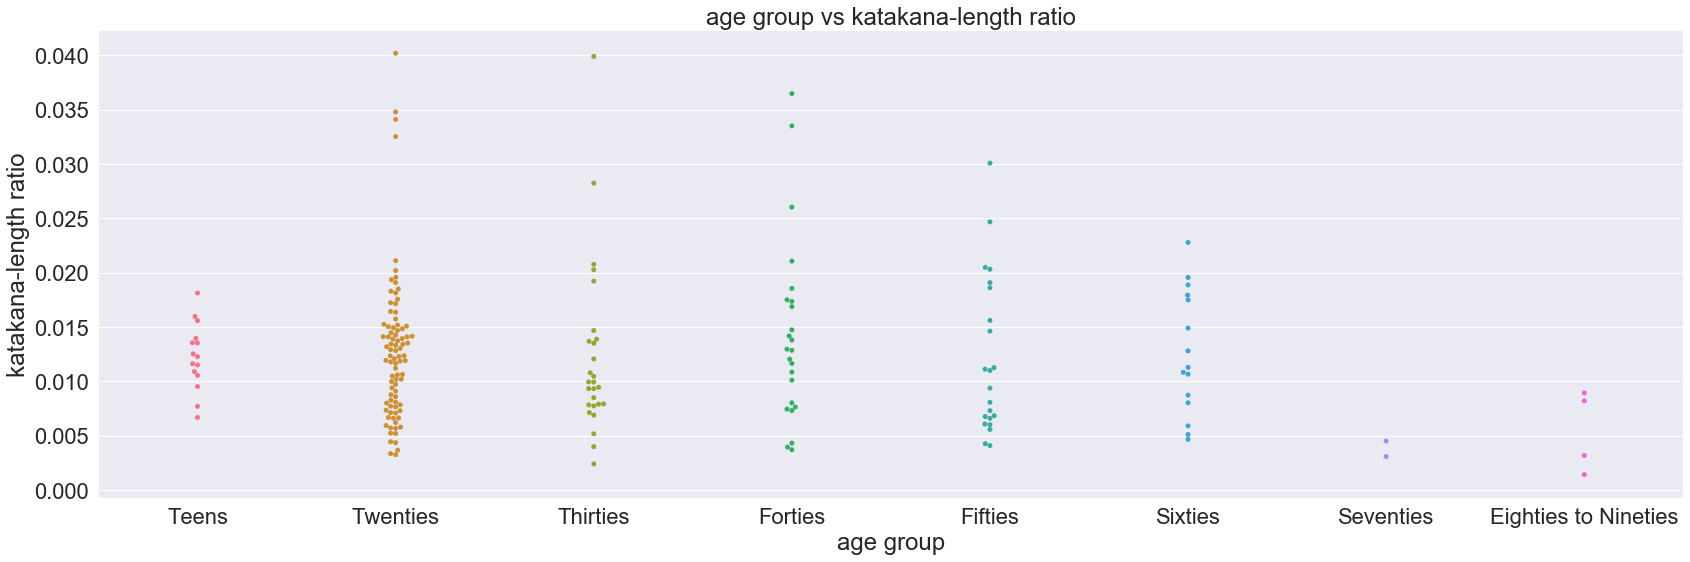

In [95]:
ax5 = sns.catplot(x='age_group', y='kata_len_ratio', kind='swarm', data=bypar, height=8, aspect=3, palette="husl")
ax5.set(title="age group vs katakana-length ratio", xlabel="age group", ylabel="katakana-length ratio")

It's pretty easy to see here that there are more younger participants than older. It does look like there's a correlation, albeit a very weak one. Let's check it out before I go into mixed effects:

In [96]:
stats.spearmanr(bypar['age_group_num'], bypar['kata_len_ratio']).correlation # checking both...

-0.0957042175164493

There seems to be very little correlation, if any, between age and katakana use, at least in this context. I did expect this correlation to be a bit stronger since there are more younger speakers than older, but it looks like this wasn't enough to create a correlation. On the contrary, it looks like there's a pretty common katakana-to-length ratio between 0.005 and 0.02, featuring some outliers. The outliers from ages 20 to 60 do drop by some amount, with a big drop off in the 70-90 age range. It is safe to say, at the very least, that senior citizens tend to use less Katakana words. 
  
  
As I'm writing this, I'm finding myself wanting to regroup these. I'm thinking about how, despite the fact that I'm a late teen, there's little difference between how I speak and how my 20something-year-old relatives speak. I'm going to take the next few steps here and assign each age group a generation. According to the [ISOGG Wiki](https://isogg.org/wiki/How_long_is_a_generation%3F_Science_provides_an_answer), a generation is, on average, 25 years long. I'm going to round this up to 30 years because the exact age of these participants isn't given. From here, if I can, I'm going to do some machine learning based on this. I was going to work with mixed effects, but I'm running out of time so I don't know how likely that'll be. 

In [97]:
bypar['generation'] = 0

In [98]:
for i in range(len(bypar)):
    if bypar['age_group_num'][i] == 10:
        bypar['generation'][i] = 1
    elif bypar['age_group_num'][i] <= 20:
        bypar['generation'][i] = 2
    elif bypar['age_group_num'][i] <= 40:
        bypar['generation'][i] = 3
    elif bypar['age_group_num'][i] <= 60:
        bypar['generation'][i] = 4
    else:
        bypar['generation'][i] = 5
        

In [99]:
bypar['generation'].value_counts()

2    88
3    51
4    37
1    15
5     6
Name: generation, dtype: int64

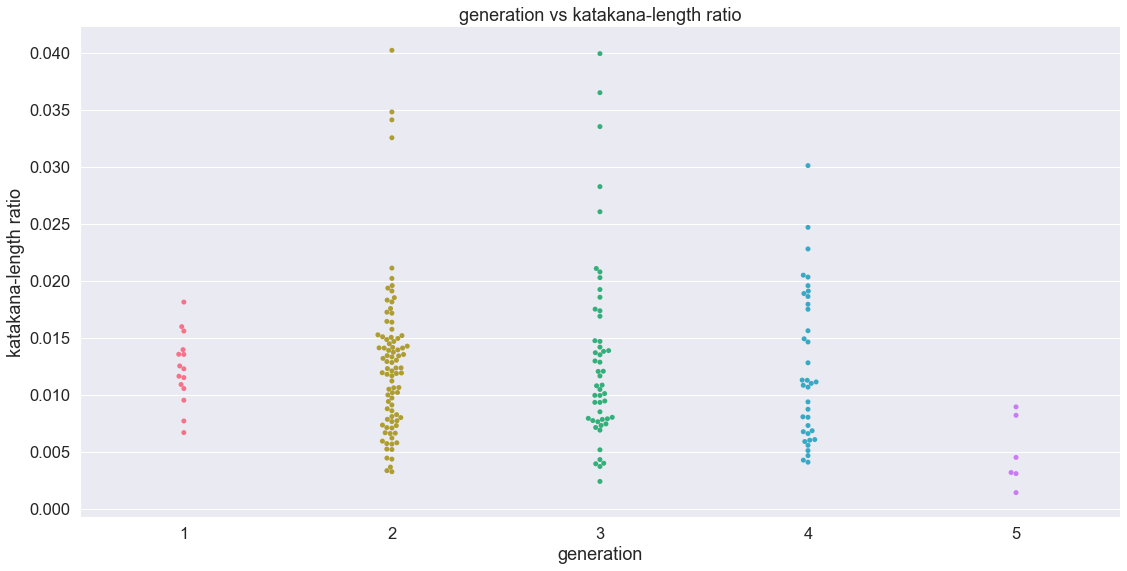

In [100]:
sns.set(font_scale=1.5)

ax6 = sns.catplot(x='generation', y='kata_len_ratio', kind='swarm', data=bypar, height=8, aspect=2, palette="husl")
ax6.set(title="generation vs katakana-length ratio", xlabel="generation", ylabel="katakana-length ratio")

Still not really an equal distribution by any means, but better than what we were working with before. Let's completely ignore the definition of generation and try to get it even more equal. 

In [101]:
for i in range(len(bypar)):
    if bypar['age_group_num'][i] == 10 or bypar['age'][i] == "Early 20s":
        bypar['generation'][i] = "A"
    elif bypar['age'][i] == "Late 20's" or bypar['age_group_num'][i] == 30 :
        bypar['generation'][i] = "B"
    elif bypar['age_group_num'][i] < 60:
        bypar['generation'][i] = "C"
    else:
        bypar['generation'][i] = "D"
    

In [102]:
bypar['generation'].value_counts()

B    66
A    64
C    46
D    21
Name: generation, dtype: int64

In [103]:
bypar['generation'] = pd.Categorical(bypar['generation'], ["A", "B", "C", "D"])

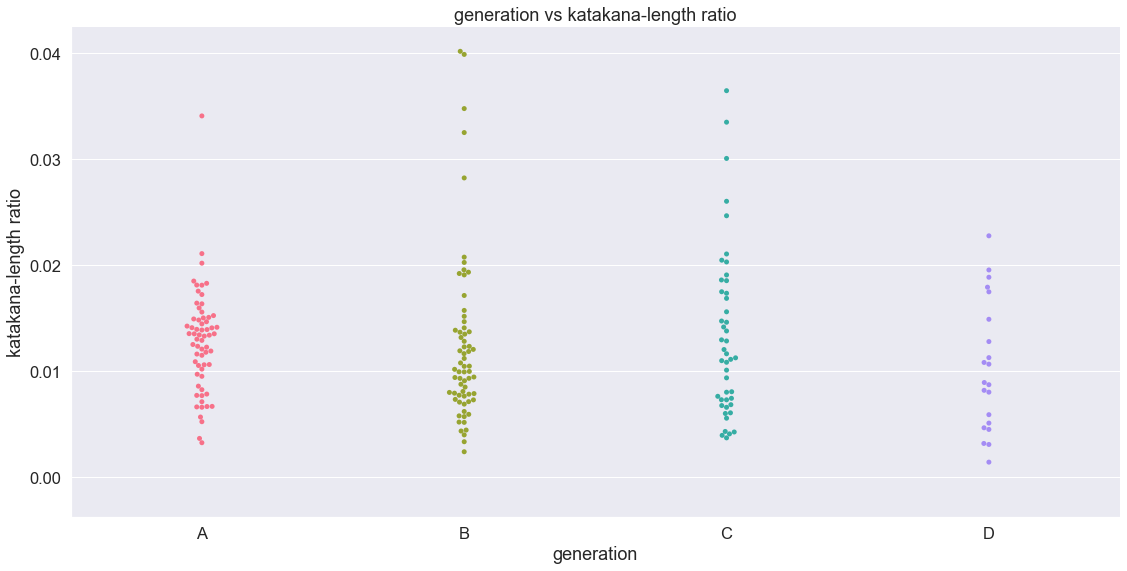

In [104]:
ax7 = sns.catplot(x='generation', y='kata_len_ratio', kind='swarm', data=bypar, height=8, aspect=2, palette="husl")
ax7.set(title="generation vs katakana-length ratio", xlabel="generation", ylabel="katakana-length ratio")

Nice! Older generations are still underrepresented, but this is more equal than it was before. I could make it almost completely equal if I put everyone 40 and over into generation 3, but then there would be too much range in that generation. 
### Wrapping Up Age vs. Katakana Use<a class="anchor" id="final-avk"></a>
We already know that this correlation, if it exists, will be a very weak one. Five-year (early/late x decade, what we originally had) and ten-year intervals didn't give us anything we could work with. However, these gaps weren't anywhere close to equally distributed. Now that we have the data in a place that we can work with and mayyybe get a good correlation going, let's do a correlation check:

In [105]:
stats.spearmanr(bypar['generation'], bypar['kata_len_ratio']).correlation 

-0.11294590953493873

If this is a correlatoin, it's a very very weak one. The fact that the teenagers didn't use very much katakana is probably what's bringing this correlation downm because after generation 2, the higher ends of usage per generation steadily declines. However, there are lots of lower-end ratios for all of the age groups. Maybe it would still be worth it to look at the *average* ratio for these A-D generations. 

In [106]:
gen_a = bypar[bypar['generation'] == "A"]
gen_b = bypar[bypar['generation'] == "B"]
gen_c = bypar[bypar['generation'] == "C"]
gen_d = bypar[bypar['generation'] == "D"]

In [107]:
a_avg = gen_a['kata_len_ratio'].mean()
b_avg = gen_b['kata_len_ratio'].mean()
c_avg = gen_c['kata_len_ratio'].mean()
d_avg = gen_d['kata_len_ratio'].mean()

avgs = [a_avg, b_avg, c_avg, d_avg]

In [108]:
print("Generation KTA Averages")
print("Generation A (Teens-Early Twenties):", avgs[0])
print("Generation B (Late Twenties-Thirties):", avgs[1])
print("Generation C (Forties-Fifties):", avgs[2])
print("Generation D (Sixties-Early Nineties):", avgs[3])

Generation KTA Averages
Generation A (Teens-Early Twenties): 0.012766909495889664
Generation B (Late Twenties-Thirties): 0.012338271480237395
Generation C (Forties-Fifties): 0.013281978815331375
Generation D (Sixties-Early Nineties): 0.010426972368483237


There doesn't seem to be much of a difference from the early teens to the late fifties in terms of averages, but what we can conclude is those aged sixty and above tend to use less Katakana words. This makes some semblance of sense when we look at Japan's history regarding American culture. 
  
  
This conversational data is from 2001, almost two decades ago. The oldest group of people, those in their early nineties, were born around 110 years ago, around the 1910s. Japan didn't go through too much thorough Westernization until post-World War II, around the late 1940s-early 1950s, which is closer to when those in generation C were born. This would explain the slight spike and persistent fluctuation of katakana ratios from generations A-C, but a big drop-off in generation D. 
  
  
It's hard to say whether this -0.11 correlation is significant or not because of the time periods that these age groups grew up in. Perhaps, if I had data that was a bit older that had more pre-World War speakers, I would be able to find a bigger correlation. However, I will conclude that given what we see in the data and given what I know about Japanese history, **there is a very weak but still existent negative correlation between Katakana use and age.**
### Concluding Remarks<a class="anchor" id="concl"></a>
What a past few weeks it's been! I didn't really get to do all that I wanted (like work with mixed-effects and machine learning), but I'm proud of what I've accomplished. I'm taking Computational Linguistics in the fall, so maybe I'll revisit this project with some new knowledge I've gathered. 
  
  
As I mentioned just above, I feel like I would've found a better correlation if I had more data from pre-Westernized Japan, but I did the best I could with what I had. I honestly consider myself lucky for finding good data in the form of .txt files as it made things much easier to work with. 
  
  
It was fun to combine two of my interests (coding and linguistics) in this class and I learned a lot! The last thing I'll do here is export my graphs. Happy Summer!

In [109]:
ax1.get_figure().savefig('../images/participant_count.png')
ax2.get_figure().savefig('../images/sample_lvf.png')
ax3.savefig('../images/lvf.png')
ax4.savefig('../images/agegroup_length_box.png')
ax5.savefig('../images/agegroup_length_swarm.png')
ax6.savefig('../images/generation_test.png')
ax7.savefig('../images/generation_final.png')